задание с курса https://expf.ru/


**Манн-Уитни** и Бутстрап проверяют разные гипотезы. С помощью бутстрапа мы проверяем нулевую гипотезу о равенстве средних, а Манн-Уитни о равенстве распределений. Манн-Уитни как и любой статистический оценщик не очень приветлив к дисбалансу. Это сказывается в первую очередь на мощности критерия – чем сильнее дисбаланс, тем реже критерий будет обнаруживать реальную разницу (эффект). 


**Бутстрап**     
Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва    
В полученных подвыборках считаются статистики (среднее, медиана и т.п.)     
Из статистик можно получить ее распределение и взять доверительный интервал     
ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать
    
    

 ### Описание эксперимента
 
>Перед вами таблица, где числовая переменная – непрерывная. Задача – сравнить группы двумя способами: бутстрапом и u-тестом

Описание колонок

    value – значения метрики
    experimentVariant – Вариант теста (Control – контроль, Treatment – тест)
    
Задача
 >Сравните результат между тестом и контролем по двум кейсам:

    Примените бутстрап (с np.mean) и критерий mann-whitney, а потом сравните p-value
    Примените бутстрап (с np.median) и критерий mann-whitney, а потом сравните p-value.


In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm, mannwhitneyu
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

plt.style.use('ggplot')

In [2]:
hw = pd.read_csv('hw_bootstrap.csv', sep =';')

In [3]:
hw.experimentVariant.value_counts()

Treatment    500
Control      500
Name: experimentVariant, dtype: int64

In [4]:
hw.value = hw.value.apply(lambda x: x.replace(',','.'))

In [5]:
hw.value = hw.value.astype('float')

In [6]:
hw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1000 non-null   int64  
 1   value              1000 non-null   float64
 2   experimentVariant  1000 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 23.6+ KB


<AxesSubplot:xlabel='experimentVariant', ylabel='value'>

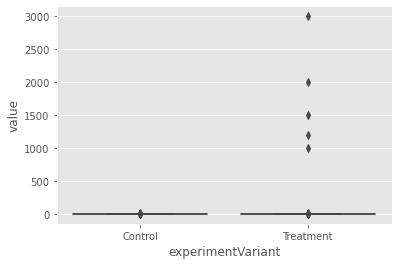

In [7]:
sns.boxplot(x="experimentVariant", y="value", data=hw)

In [8]:
hw.groupby('experimentVariant', as_index=False).agg({'value': ('mean','median')})

experimentVariant      value           
                          mean     median
0           Control  10.026867  10.018465
1         Treatment  27.321499  10.025847

C:\Users\maksa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value', ylabel='Density'>

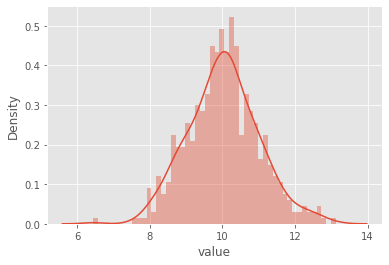

In [9]:
a = hw.query('experimentVariant == "Control"')
sns.distplot(a.value, bins=50)

C:\Users\maksa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='value', ylabel='Density'>

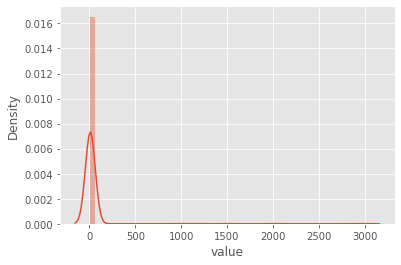

In [10]:
b = hw.query('experimentVariant == "Treatment"')
sns.distplot(b.value, bins=50)

In [11]:
# посчитаем выбросы
hw.query('experimentVariant == "Treatment" and value > 27').count()

Unnamed: 0           5
value                5
experimentVariant    5
dtype: int64

  Используем критерий Манна_Уитни: нам не нужно предполагать, что наши данные соответствуют нормальному распределению
  
     Нулевая гипотеза:  различий между выборками нет (равенство распределений)

In [12]:
from scipy.stats import mannwhitneyu

# Carrying out the Wilcoxon–Mann–Whitney test
results = mannwhitneyu(a.value, b.value)
results

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)

 pvalue=0.8592148582485579  > 0.05,  
 
 Н0 -  Равенство распределений : **подтверждаем**.

#### Определяем функцию "get_bootstrap". 
https://expf.ru/

In [13]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []  
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value,
            }

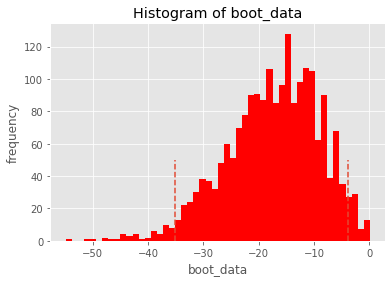

In [14]:
# будем пробовать бутстрап для средних

booted_data = get_bootstrap(a.value, b.value, boot_it = 2000) # в результате хранится разница двух распределений, ДИ и pvalue

In [15]:
booted_data["p_value"]

0.03914992499921816

In [16]:
booted_data["quants"]

,0
0.025,-35.083755
0.975,-3.896076


 Ноль НЕ попадает в доверительный интервал. **Нулевую гипотезу** о равенстве выборочных средних - **отклоняем**.
 
 Bootstrap "посчитал" эту разницу для средних значимым различием (и р < 0.05), в отличае от критерия Манна-Уитни.

#### Попробуем bootstrap от **scipy.stats**

In [17]:
from scipy.stats import bootstrap

df = pd.DataFrame()
df['sample difference'] = a['value'] - b['value'].reset_index(drop=True)

#convert array to sequence
data = (df['sample difference'],)

#calculate 95% bootstrapped confidence interval for mean
bootstrap_ci = bootstrap(data, 
                         np.mean,
                         confidence_level=0.95,
                         n_resamples=1000,
                         method='percentile')

#view 95% boostrapped confidence interval
print(bootstrap_ci.confidence_interval)

ConfidenceInterval(low=-35.59873701647361, high=-2.9824398190024985)


Также: Ноль НЕ попадает в доверительный интервал. **Нулевую гипотезу** о равенстве выборочных средних - **отклоняем**.

#### Будем пробовать бутстрап для медиан:

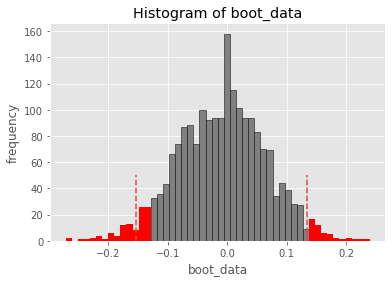

In [18]:
booted_data2 = get_bootstrap(a.value, b.value, statistic = np.median, boot_it = 2000) 

In [19]:
booted_data2["p_value"]

0.9004592143826802

In [20]:
booted_data2["quants"]

,0
0.025,-0.152713
0.975,0.133882


Ноль попадает в доверительный интервал. **Нулевую гипотезу** о равенстве выборочных медиан - **подтверждаем**.

#### Удалим выбросы из  experimentVariant == "Treatment"

In [21]:
b2 = hw.query('experimentVariant == "Treatment" and value < 27')

In [22]:
b2

,Unnamed: 0,value,experimentVariant
500,501,10.380495,Treatment
501,502,9.546867,Treatment
502,503,11.088215,Treatment
503,504,10.147274,Treatment
504,505,9.789808,Treatment
...,...,...,...
990,991,10.916229,Treatment
991,992,11.160869,Treatment
992,993,8.202518,Treatment
993,994,9.782199,Treatment


#### Будем пробовать бутстрап для средних    *!без выбросов!*    в данных.

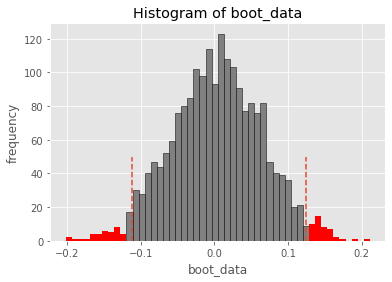

In [23]:
# будем пробовать бутстрап для средних. Без выбросов!

booted_data3 = get_bootstrap(a.value, b2.value, boot_it = 2000)

In [24]:
booted_data3["p_value"]

0.9581619845266954

Ноль попадает в доверительный интервал,  **нулевую гипотезу о равенстве средних - принимаем**.    В отличае от первого испытания.

## Итого
https://expf.ru/
* Тестовая выборка имеет большие выбросы, что сильно искажает нам среднее значение
* Применяя бутстрап с оценкой среднего, мы могли бы отклонить нулевую гипотезу о равенстве средних и сделать вывод, что тестовая и контрольная выборка имеют различия
* Однако, тот же бутстрап, но уже по медиане не дает нам отклонить нулевую гипотезу, так как p-value сильно больше 0.05, т.к. здесь проверяется другая гипотеза
* U-критерий Манна-Уитни так же не дал бы нам отклонить нулевую гипотезу. Оценки pvalue так же направлены как у бутстрапирования медианы